# 编码注意力机制

- 探索在神经网络中使用注意力机制的原因
- 介绍基本的自注意力框架，并逐步过渡到增强的自注意力机制
- 实现一个因果注意力模块，使大语言模型（LLMs）能够一次生成一个标记（token）
- 通过dropout随机掩盖注意力权重以减少过拟合
- 将多个因果注意力模块堆叠成多头注意力模块

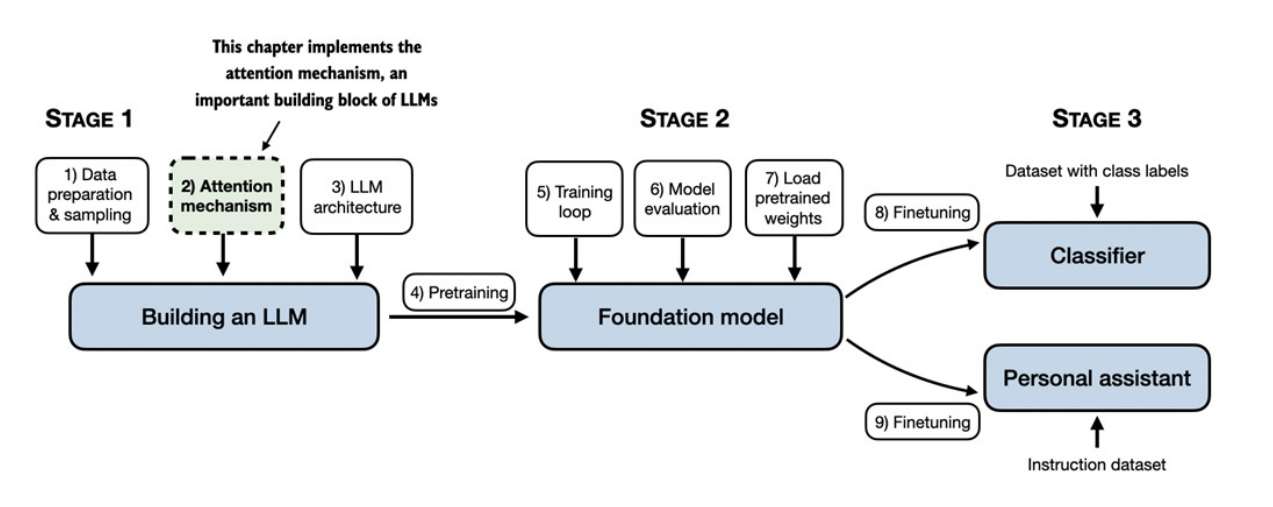

图3-1：一个关于编写大型语言模型（LLM）的三个主要阶段的思维导图：在通用文本数据集上对LLM进行预训练，并在标记数据集上对其进行微调。本章重点关注注意力机制，这是LLM架构的一个不可或缺的部分。

在本章中，我们将实现四种不同的注意力机制变体。

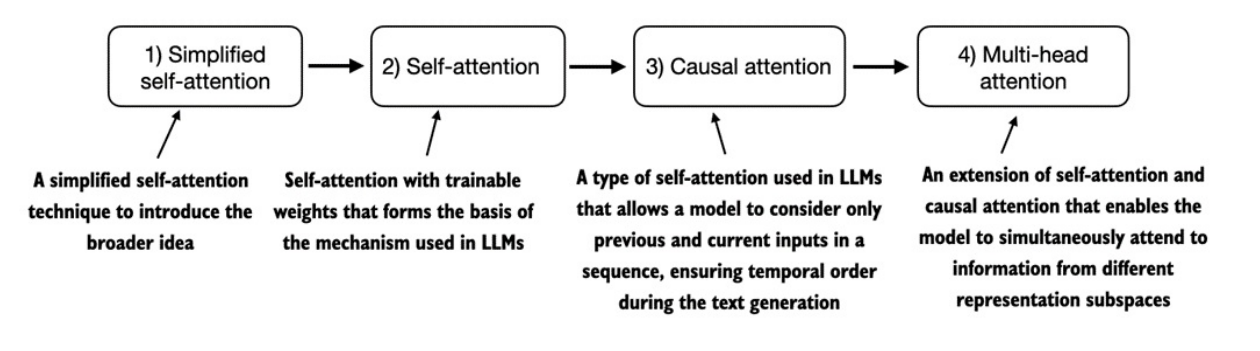

图3-2：该图展示了本章中我们将编写的不同注意力机制，首先是从自注意力机制的简化版本开始，然后再添加可训练权重。因果注意力机制在自注意力机制上添加了一个掩码，这使得大型语言模型（LLM）能够一次生成一个单词。最后，多头注意力将注意力机制组织成多个头，从而使模型能够并行捕获输入数据的各个方面。

## 建模长序列的问题

在本章稍后深入探讨作为大型语言模型（LLM）核心的自注意力机制之前，我们先来看看在LLM之前，没有注意力机制的架构存在什么问题？

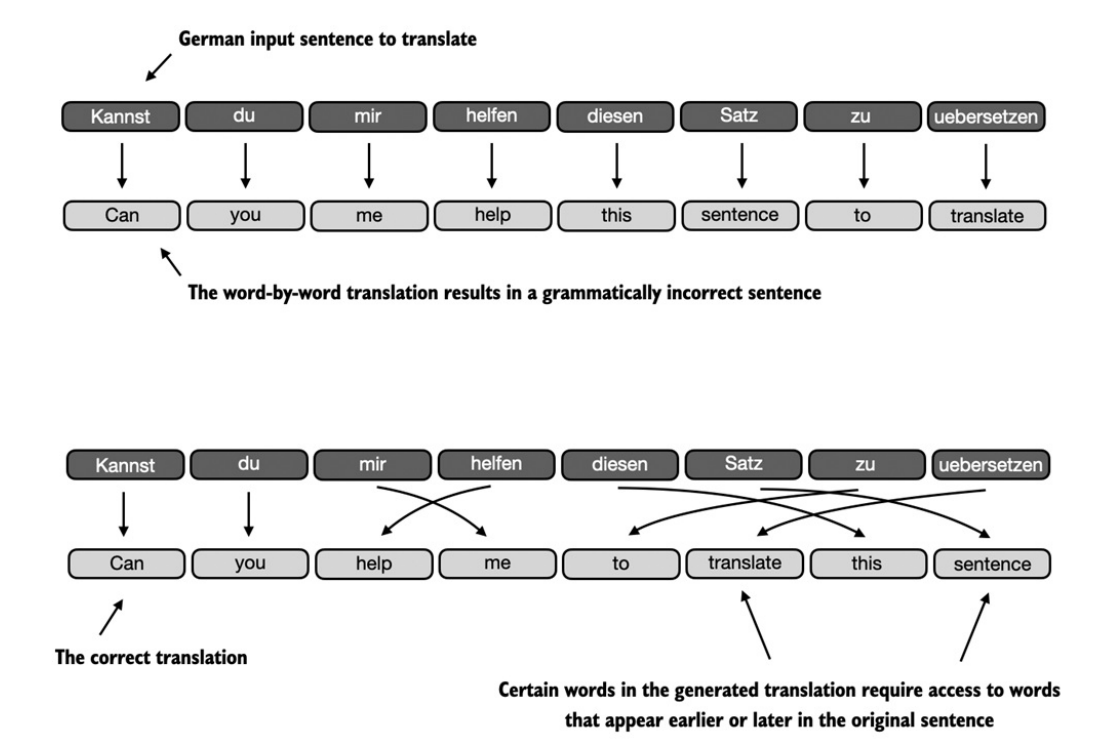

图3-3：当将文本从一种语言翻译成另一种语言，比如从德语翻译成英语时，不可能仅仅逐字翻译。相反，翻译过程需要理解上下文和对语法的调整。

为了解决不能逐字翻译文本的问题，通常使用包含两个子模块（即所谓的编码器和解码器）的深度神经网络。编码器的任务是首先读取并处理整个文本，然后解码器生成翻译后的文本。

RNNs：https://www.bilibili.com/video/BV1z5411f7Bm/?spm_id_from=333.880.my_history.page.click&vd_source=abc245504e26b2d6288134b8d96cf6e1

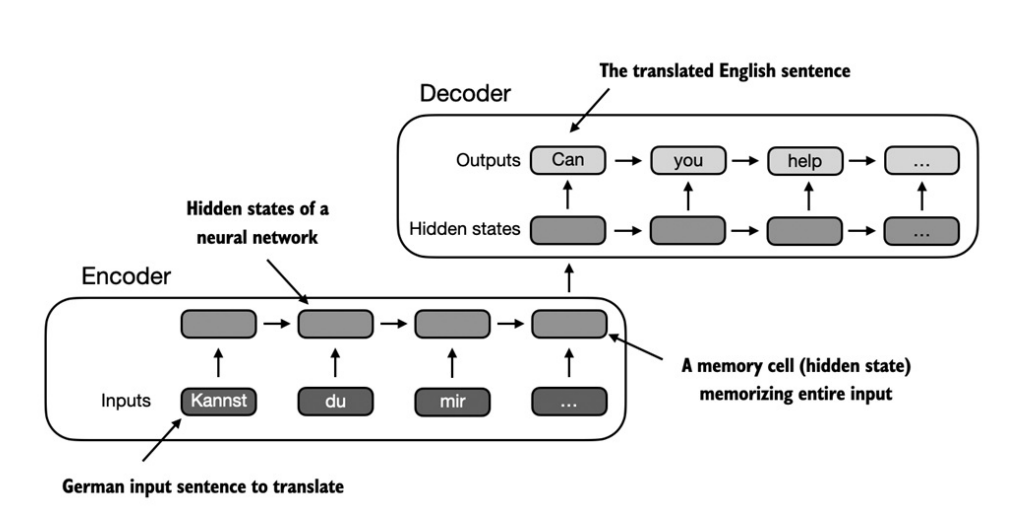

图3-4：在Transformer模型出现之前，编码器-解码器循环神经网络（RNN）是机器翻译中的一种流行选择。编码器将源语言的一系列词元作为输入，其中编码器的隐藏状态（一个中间神经网络层）对整个输入序列的压缩表示进行编码。然后，解码器利用其当前的隐藏状态开始逐词进行翻译。

RNN的这里的关键思想是编码器部分将整个输入文本处理成一个隐藏状态（记忆单元）。然后，解码器接收这个隐藏状态来产生输出。你可以将这个隐藏状态看作是一个嵌入向量。

编码器-解码器循环神经网络（RNN）的局限性是，在解码阶段，RNN无法直接访问编码器中的早期隐藏状态。因此，它仅依赖于当前的隐藏状态，该状态包含了所有相关信息。这可能会导致上下文的丢失，特别是在依赖关系可能跨越长距离的复杂句子中。

## 使用注意力机制捕获数据依赖关系

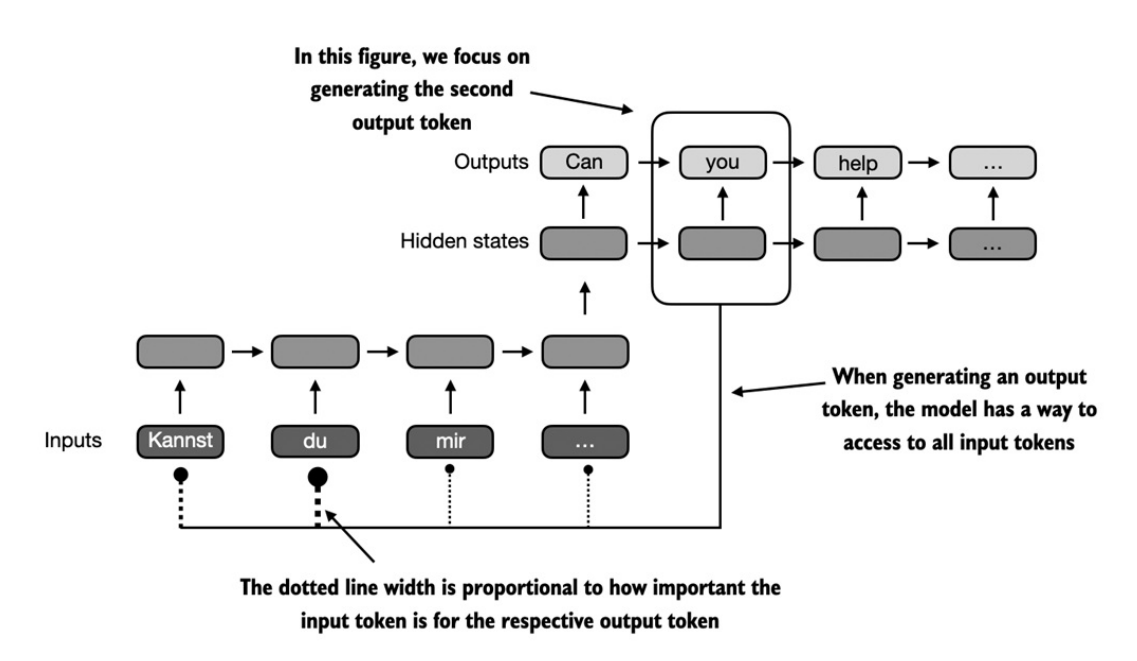

图3-5：通过使用注意力机制，网络的文本生成解码器部分可以有选择地访问所有输入词元。这意味着在生成特定的输出词元时，一些输入词元比其他词元更重要。这种重要性由所谓的注意力权重决定，我们将在后面进行计算。请注意，此图展示了注意力背后的基本思想，并没有描绘Bahdanau机制的具体实现，因为那是一种循环神经网络（RNN）方法，超出了本书的范围。

自注意力是一种机制，它允许在计算序列的表示时，输入序列中的每个位置都能关注到该序列中的所有位置。自注意力是基于Transformer架构的当代大型语言模型（LLMs）的关键组件，如GPT系列模型。

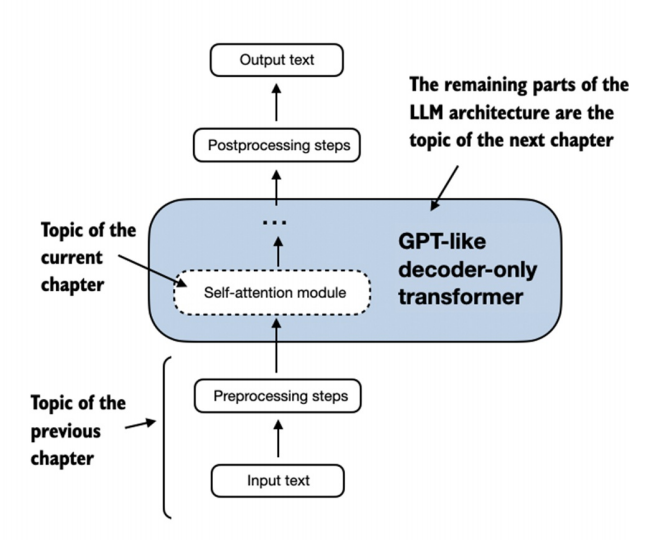

图3-6：自注意力是Transformer中的一种机制，它允许序列中的每个位置与同一序列内的所有其他位置进行交互并衡量其重要性，从而计算出更有效的输入表示。在本章中，我们将从头开始编码这种自注意力机制，然后在下一章中编码GPT类大型语言模型（LLM）的其余部分。

## 使用自注意力关注输入的不同部分

#### 自注意力中的“自”

在自注意力中，“自”指的是机制通过关联单个输入序列内不同位置来计算注意力权重的能力。它评估和学习输入本身各部分之间的关系和依赖，例如句子中的单词或图像中的像素。这与传统的注意力机制形成对比，传统注意力机制的重点是两个不同序列元素之间的关系，例如在序列到序列模型中，注意力可能存在于输入序列和输出序列之间。

### 没有可训练权重的简单自注意力机制

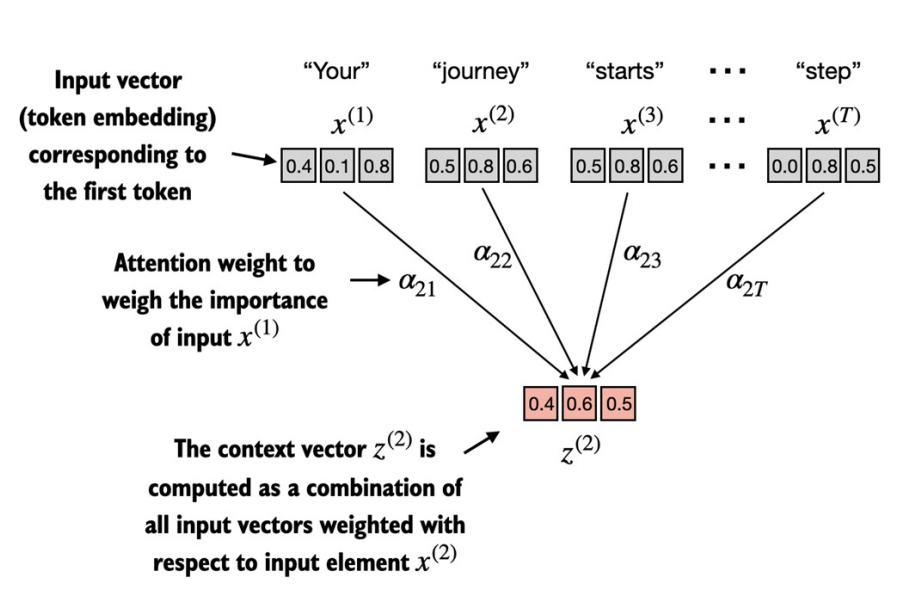

图3-7：自注意力的目标是为每个输入元素计算一个上下文向量，该向量结合了来自所有其他输入元素的信息。在本图所示的例子中，我们计算上下文向量z(2)。在计算z(2)时，每个输入元素的重要性或贡献由注意力权重α21到α2T决定。在计算z(2)时，注意力权重是相对于输入元素x(2)和所有其他输入来计算的。这些注意力权重的具体计算方法将在本节后面讨论。

在自注意力中，我们的目标是为输入序列中的每个元素x(i)计算上下文向量z(i)。上下文向量可以被解释为一种丰富的嵌入向量。

考虑以下输入句子，它已经按照第2章的讨论被嵌入到3维向量中。为了说明目的，我们选择了一个小的嵌入维度，以确保它能在页面上无换行地显示：

In [1]:
import torch
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

实现自注意力的第一步是计算中间值ω，这些值被称为注意力分数。

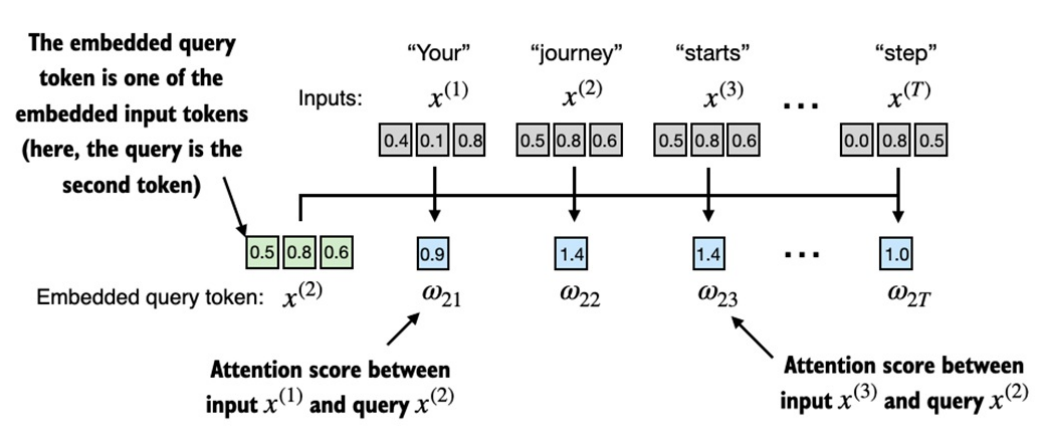

图3-8：本节的总体目标是使用第二个输入序列x(2)作为查询来阐述上下文向量z(2)的计算。该图展示了第一个中间步骤，即计算查询x(2)与所有其他输入元素之间的注意力分数ω，作为点积的结果。（注意，图中的数字被截断为小数点后一位，以减少视觉上的杂乱。）

In [3]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (由于它们是一维向量，因此无需转置)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


点积本质上是将两个向量逐元素相乘然后求和的一种简洁方式，我们可以按如下方式演示：

In [4]:
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


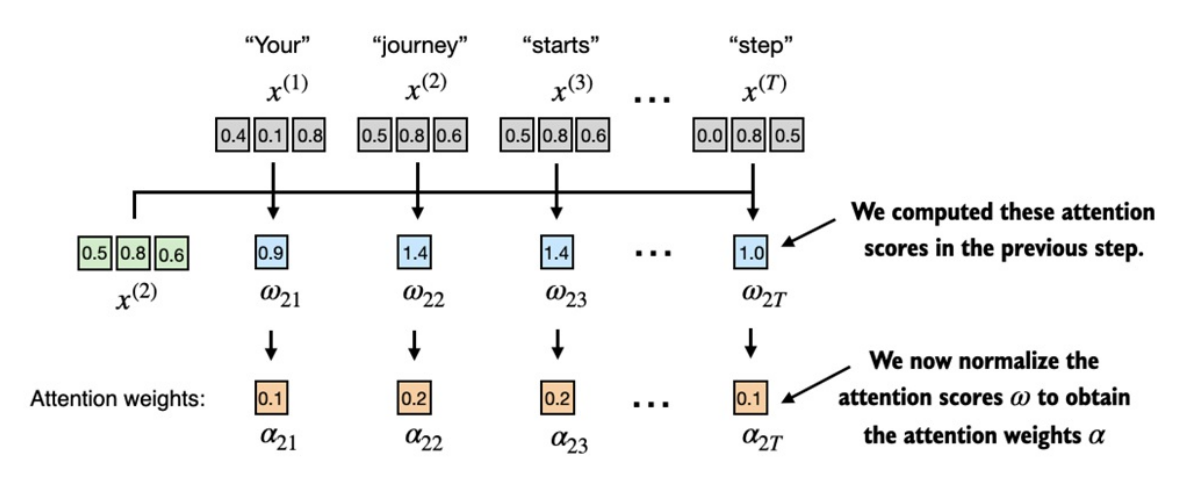

图3-9：在针对输入查询x(2)计算出注意力分数ω21到ω2T之后，下一步是通过归一化这些注意力分数来获得注意力权重α21到α2T。

In [5]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


在实际应用中，使用softmax函数进行归一化更为常见且可取。这种方法在处理极值方面表现更好，并且在训练过程中提供了更有利的梯度特性。以下是softmax函数用于归一化注意力分数的基本实现：

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0) #沿着第一个维度进行计算

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


这种朴素的softmax实现（softmax_naive）在处理较大或较小的输入值时可能会遇到数值不稳定问题，如溢出和下溢。因此，在实际应用中，建议使用PyTorch的softmax实现，因为它已经过广泛的性能优化：

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


现在我们已经计算出了归一化的注意力权重，接下来就可以进行图3.10中所示的最后一步：通过将嵌入的输入标记x(i)与相应的注意力权重相乘，然后将得到的向量相加，来计算上下文向量z(2)。

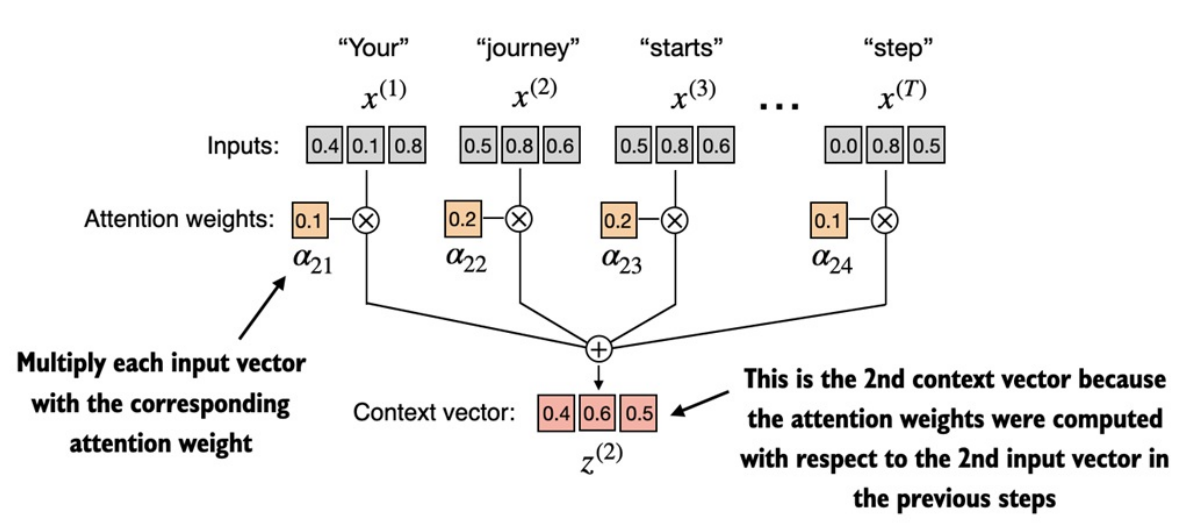

图3-10：在计算并归一化注意力分数以获得查询x(2)的注意力权重之后，最后一步是计算上下文向量z(2)。这个上下文向量是所有输入向量x(1)到x(T)通过注意力权重加权后的组合。

In [8]:
query = inputs[1] # 2nd input token is the query
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 计算所有输入词元的注意力权重

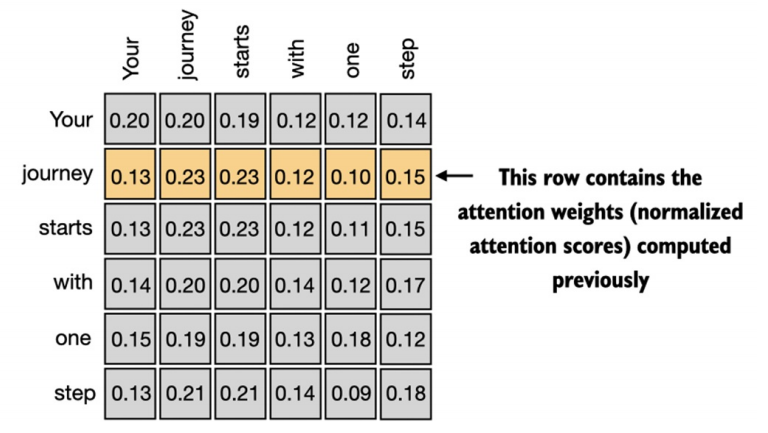

图3-11：高亮显示的行表示了第二个输入元素作为查询时的注意力权重，这是我们在上一节中计算得出的。本节将推广这种计算以获得所有其他的注意力权重。

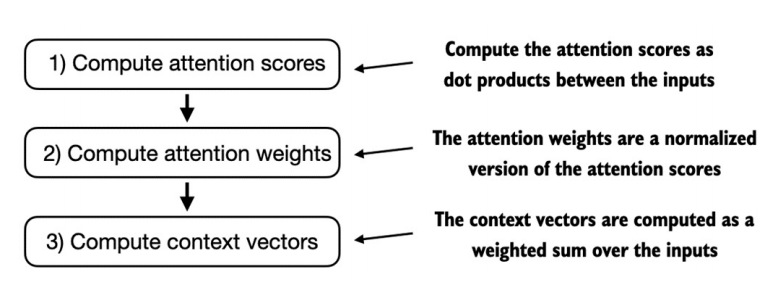

首先，如图3-12所示的第1步中，我们增加了一个额外的for循环来计算所有输入对之间的点积。

In [9]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


在计算前面的注意力分数张量时，我们使用了Python中的for循环。然而，for循环通常较慢，我们可以使用矩阵乘法来获得相同的结果：

In [10]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


在步骤2中，如图3.12所示，我们现在对每个行进行归一化，使得每行中的值之和为1：

In [11]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


在我们进入图3.12中所示的最终步骤，即步骤3之前，让我们先简要验证一下所有行的和确实都为1：

In [57]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


在第三步，也是最后一步中，我们现在使用这些注意力权重通过矩阵乘法来计算所有的上下文向量：

In [13]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [14]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## 使用可训练权重实现自注意力

在本节中，我们将实现原始Transformer架构、GPT模型以及大多数其他流行的大型语言模型（LLM）中使用的自注意力机制。这种自注意力机制也被称为缩放点积注意力。

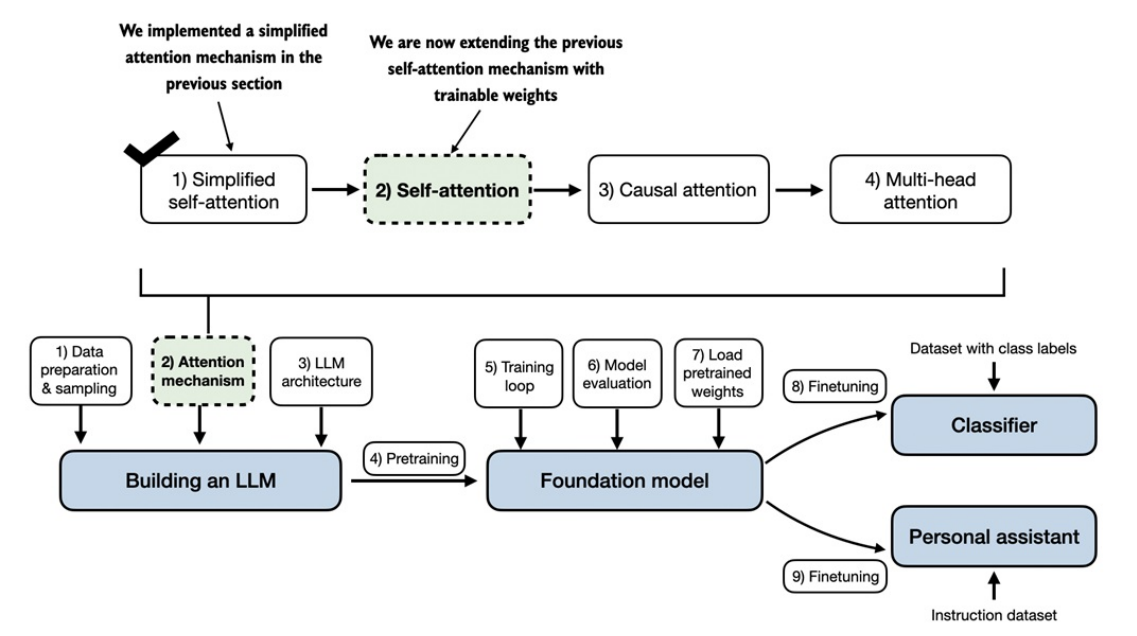

图3-13：一个思维模型，展示了我们在本节中编写的自注意力机制是如何融入本书和本章的更广泛背景中的。在上一节中，我们编写了一个简化的注意力机制来理解注意力机制背后的基本机制。在本节中，我们为这个注意力机制添加了可训练的权重。在接下来的部分中，我们还将通过添加因果掩码和多个头来扩展这个自注意力机制。

最显著的区别是引入了在模型训练过程中更新的权重矩阵。这些可训练的权重矩阵至关重要，以便模型（特别是模型内部的注意力模块）能够学习产生“良好”的上下文向量。

### 逐步计算注意力权重

我们将通过引入三个可训练的权重矩阵Wq、Wk和Wv来逐步实现自注意力机制。这三个矩阵用于将嵌入的输入标记x(i)投影为查询、键和值向量。

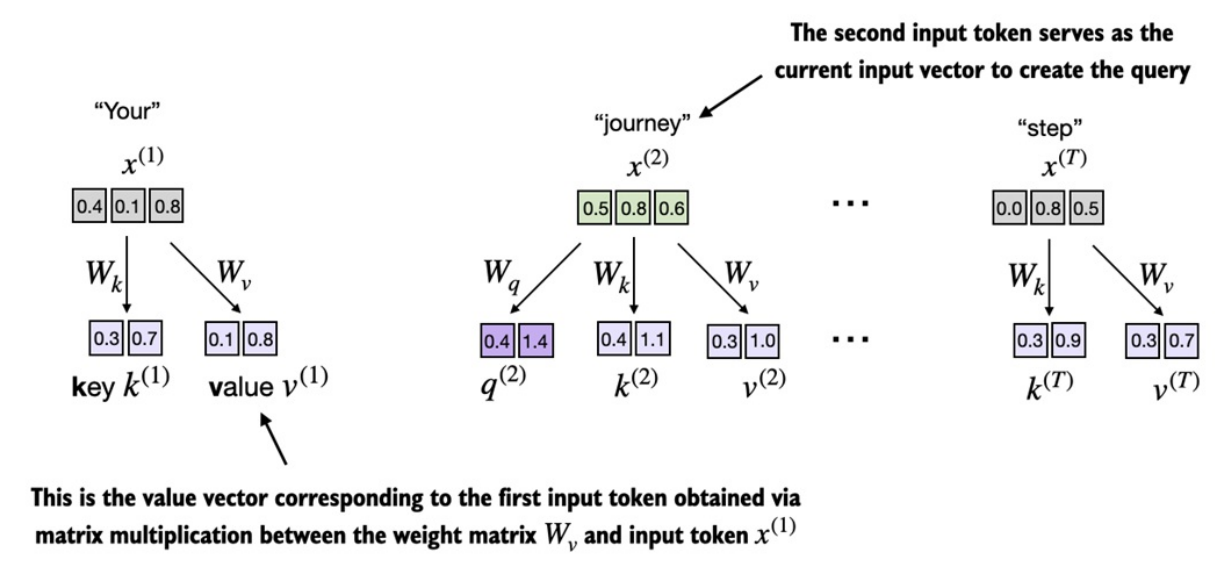

图3-14：在带有可训练权重矩阵的自注意力机制的第一步中，我们为输入元素x计算查询（q）、键（k）和值（v）向量。与前面的部分类似，我们将第二个输入x(2)指定为查询输入。查询向量q(2)是通过输入x(2)和权重矩阵Wq之间的矩阵乘法获得的。同样，我们通过涉及权重矩阵Wk和Wv的矩阵乘法来获得键和值向量。

为了说明目的，我们将首先只计算一个上下文向量z(2)。

让我们先从定义一些变量开始：

In [15]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

接下来，我们初始化在图3.14中所示的三个权重矩阵Wq、Wk和Wv：

In [17]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

- torch.rand是PyTorch中的一个函数，用于生成一个给定形状的张量（Tensor），其元素是从均匀分布U（0，1）中随机抽取的。
- requires_grad是torch.nn.Parameter构造函数的一个参数，用于指定是否需要计算该参数的梯度。

接下来，我们计算查询、键和值向量：

In [18]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


#### 权重参数与注意力权重

请注意，在权重矩阵W中，“权重”是“权重参数”的简称，这些值是神经网络在训练过程中优化的。这与注意力权重不同，不应混淆。正如我们在上一节已经看到的，注意力权重决定了上下文向量在多大程度上依赖于输入的不同部分，即网络在多大程度上关注输入的不同部分。总之，权重参数是定义网络连接的基本学习系数，而注意力权重是动态的、特定于上下文的值。

我们可以通过矩阵乘法获得所有键和值：

In [19]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


下一步是计算注意力分数。

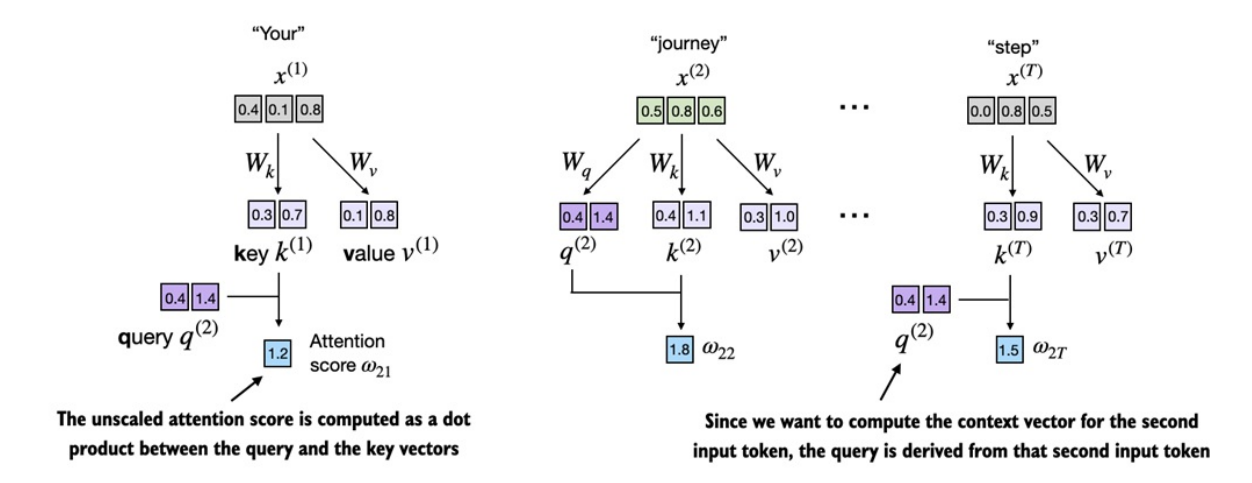

图3-15：注意力分数的计算是一个点积计算，类似于我们在3.3节中简化的自注意力机制中所使用的。这里的新特点是，我们不是直接计算输入元素之间的点积，而是使用通过相应权重矩阵转换输入后得到的查询和键来计算点积。

首先，让我们计算注意力分数ω22：

In [20]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


同样，我们可以通过矩阵乘法将此计算推广到所有注意力分数：

In [21]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


第三步是从注意力分数到注意力权重的转换。

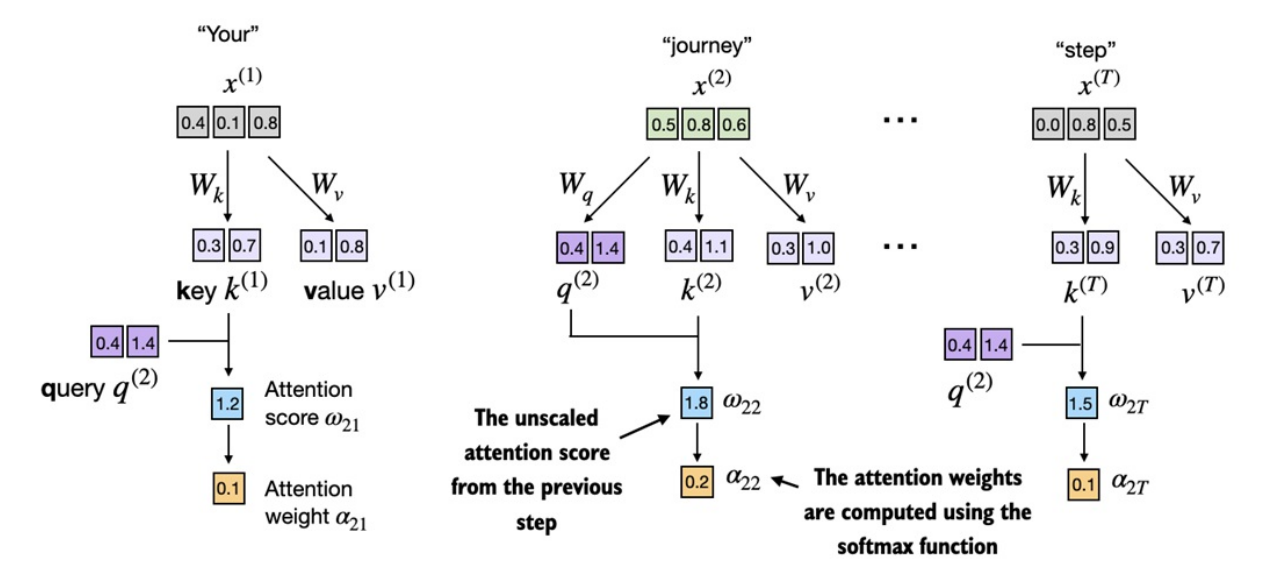

图3-16：在计算完注意力分数ω之后，下一步是使用softmax函数对这些分数进行归一化，以获得注意力权重α。

接下来，我们通过缩放注意力分数并使用之前使用的softmax函数来计算注意力权重。与之前不同的是，我们现在通过用键的嵌入维度的平方根（注意，取平方根在数学上等同于0.5次幂）来除注意力分数，从而对注意力分数进行缩放：

In [25]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


#### 缩放点积注意力背后的原理

通过嵌入维度大小进行归一化的原因是为了避免梯度过小，从而提高训练性能。例如，当扩大嵌入维度（对于GPT等大型语言模型来说，嵌入维度通常大于一千）时，由于对这些点积应用了softmax函数，反向传播过程中可能会产生非常小的梯度。随着点积的增大，softmax函数的行为更像是一个阶跃函数，导致梯度接近零。这些过小的梯度会极大地减缓学习过程或导致训练停滞不前。

通过嵌入维度的平方根进行缩放是自注意力机制也被称为缩放点积注意力的原因。

最后一步是计算上下文向量。

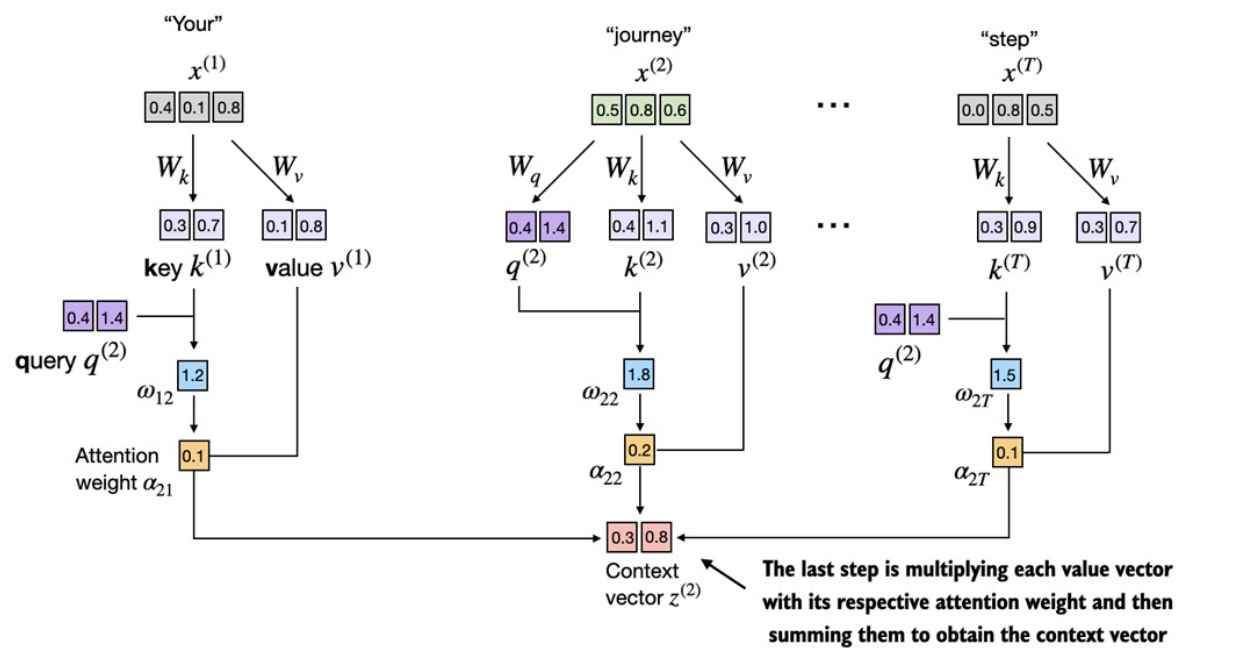

图3-17：在自注意力计算的最后一步中，我们通过注意力权重将所有值向量组合起来，从而计算出上下文向量。

与3.3节中我们计算上下文向量作为输入向量的加权和类似，现在我们计算上下文向量作为值向量的加权和。在这里，注意力权重作为权重因子，衡量每个值向量的相对重要性。与3.3节类似，我们可以使用矩阵乘法一步得到输出：

In [26]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### 为什么使用查询（query）、键（key）和值（value）？

在注意力机制中，“键（key）”、“查询（query）”和“值（value）”这三个术语是从信息检索和数据库领域借用的，这些领域中使用了类似的概念来存储、搜索和检索信息。
- “查询”类似于数据库中的搜索查询。它代表模型当前关注或试图理解的项（例如，句子中的一个单词或标记）。查询用于探测输入序列的其他部分，以确定应对其给予多少注意力。
- “键”就像数据库中用于索引和搜索的键一样。在注意力机制中，输入序列中的每个项（例如，句子中的每个单词）都有一个相关联的键。这些键用于与查询进行匹配。
- “值”在这个上下文中类似于数据库中键值对中的值。它代表输入项的实际内容或表示。一旦模型确定了哪些键（以及因此输入中的哪些部分）与查询（当前关注的项）最相关，它就会检索相应的值。

### 实现一个简洁的自注意力Python类

In [27]:
import torch.nn as nn

class SelfAttention_v1(nn.Module): #SelfAttention_v1是从nn.Module派生的一个类

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

- __init__ 是一个特殊方法（有时称为魔术方法），用于类的初始化。当一个类的实例（即对象）被创建时，__init__ 方法会自动被调用。它的主要作用是设置对象在创建时应该有的初始状态或属性。

In [28]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


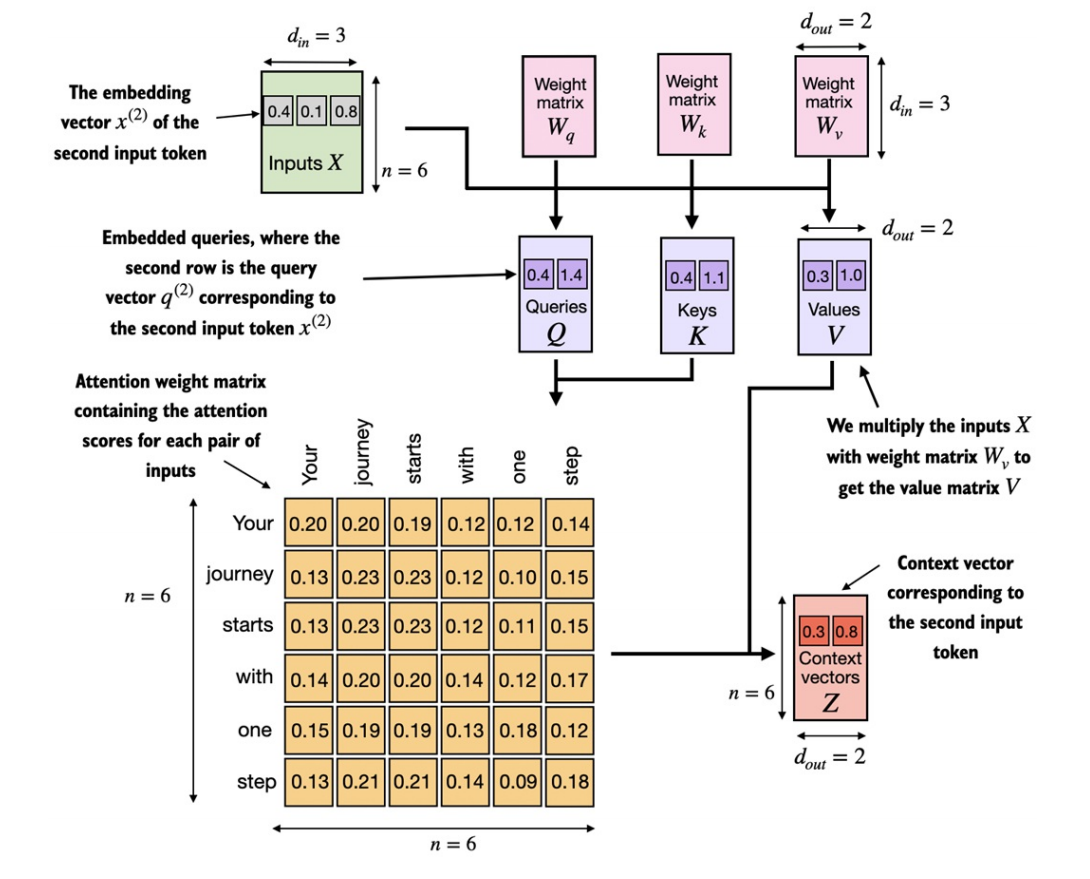

图3-18：在自注意力中，我们使用三个权重矩阵Wq、Wk和Wv对输入矩阵X中的输入向量进行变换。然后，我们根据得到的查询（Q）和键（K）来计算注意力权重矩阵。接着，我们使用注意力权重和值（V）来计算上下文向量（Z）。（为了视觉清晰，本图聚焦于一个包含n个标记的单个输入文本，而不是多个输入的批次。因此，在这个上下文中，3D输入张量被简化为2D矩阵。这种方法可以更直观地可视化和理解所涉及的过程。）

我们可以进一步改进SelfAttention_v1的实现，通过使用PyTorch的nn.Linear层，当禁用偏置单元时，这些层可以有效地执行矩阵乘法。此外，使用nn.Linear而不是手动实现nn.Parameter(torch.rand(...))的一个显著优势是，nn.Linear具有优化的权重初始化方案，有助于模型训练更加稳定和有效。

In [30]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

- nn.Linear：这是PyTorch中定义线性层的类。线性层执行y = xA^T + b的操作，其中x是输入，A是权重矩阵，b是偏置项（如果bias=True），y是输出。

In [33]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


#### 练习3.1 比较SelfAttention_v1和SelfAttention_v2

将SelfAttention_v2实例的权重正确分配给SelfAttention_v1实例。

提示：nn.Linear以转置形式存储权重矩阵。

## 使用因果注意力隐藏未来的词

因果注意力，也称为掩码注意力，是自注意力的一种特殊形式。它限制模型在处理任何给定标记时仅考虑序列中的先前和当前输入。这与标准自注意力机制形成对比，后者允许一次性访问整个输入序列。因此，在计算注意力分数时，因果注意力机制确保模型仅考虑序列中当前标记之前或当前标记的标记。

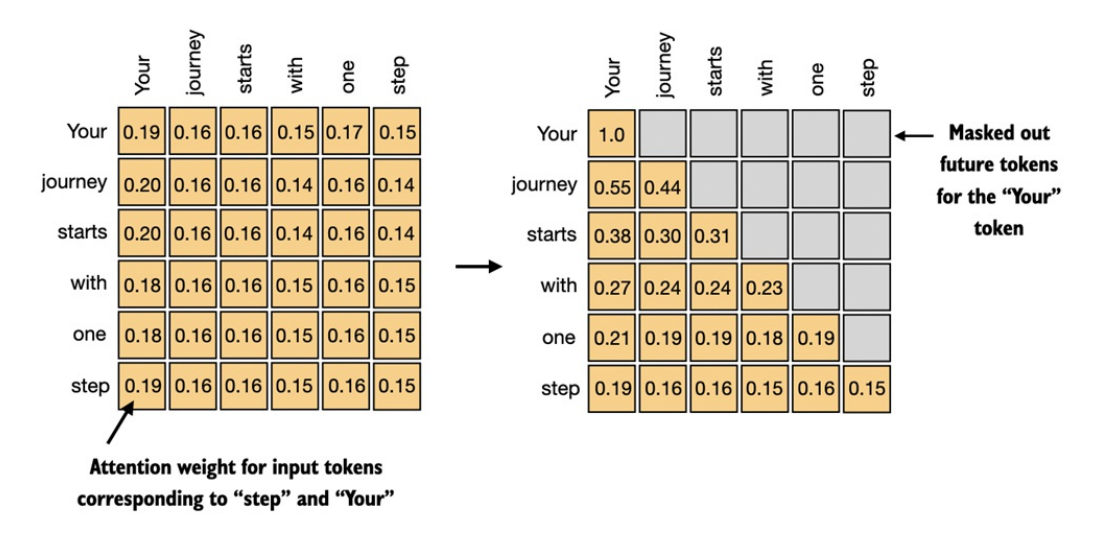

图3-19：在因果注意力中，我们屏蔽掉对角线上方的注意力权重，以便对于给定的输入，当使用注意力权重计算上下文向量时，大型语言模型无法访问未来标记。例如，对于第二行中的单词“journey”，我们仅保留其之前（“Your”）和当前位置（“journey”）的单词的注意力权重。

### 应用因果注意力掩码

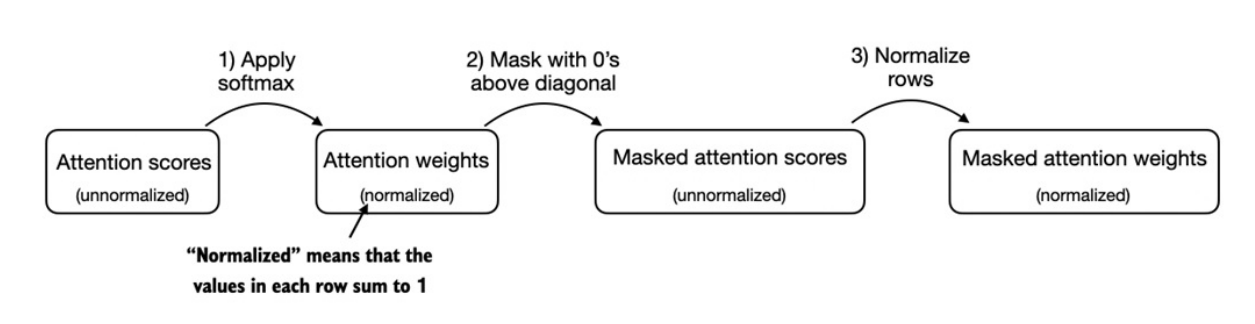

图3-20：在因果注意力中获得掩码注意力权重矩阵的一种方法是对注意力分数应用softmax函数，将对角线上方的元素置零，并对得到的矩阵进行归一化。

第一步，我们一样使用softmax函数来计算注意力权重：

In [34]:
# Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


我们可以使用PyTorch的tril函数来实现第2步，该函数创建一个掩码，其中对角线上方的值为零：

In [35]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


- torch.ones(context_length, context_length): 这个函数创建一个形状为(context_length, context_length)的张量（Tensor），其中所有元素的值都是1。context_length是一个整数，表示矩阵的维度（即矩阵是context_length x context_length的）。
- torch.tril(...): 这个函数接收一个二维张量作为输入，并返回一个新的二维张量，该张量是一个下三角矩阵。下三角矩阵是指矩阵中主对角线以下（包括主对角线）的元素为原张量中对应的值，而主对角线以上的元素都为0。在这个上下文中，由于输入张量的所有元素都是1，所以返回的下三角矩阵在主对角线及其以下的元素都是1，而主对角线以上的元素都是0。

现在，我们可以将这个掩码与注意力权重相乘，将对角线上方的值置零：

In [36]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


第三步是重新归一化注意力权重，使每行的权重之和再次为1。我们可以通过将每行中的每个元素除以该行的和来实现这一点：

In [37]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


#### 信息泄露

当我们应用掩码然后重新归一化注意力权重时，起初可能会觉得来自未来标记（我们打算掩蔽的）的信息仍然可能影响当前标记，因为它们的值是softmax计算的一部分。然而，关键之处在于，当我们在掩蔽后重新归一化注意力权重时，我们实际上是在一个更小的子集上重新计算softmax（因为掩蔽位置不对softmax值做贡献）。

softmax的数学优雅之处在于，尽管最初在分母中包括了所有位置，但在掩蔽和重新归一化后，掩蔽位置的影响被抵消了——它们不会以任何有意义的方式影响softmax分数。

简而言之，在掩蔽和重新归一化后，注意力权重的分布就好像它最初只在未掩蔽位置之间计算的一样。这确保了像我们预期的那样，没有来自未来（或其他掩蔽）标记的信息泄露。

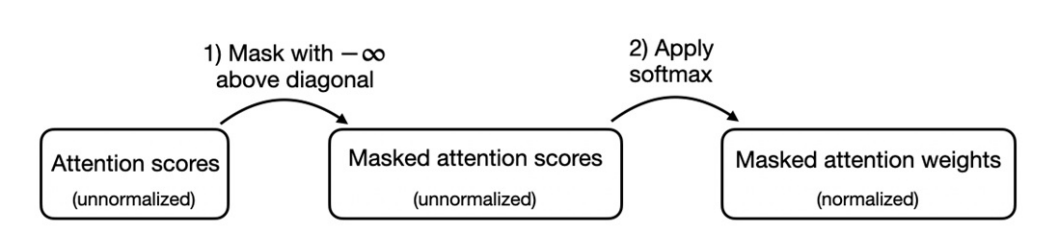

图3-21：在因果注意力中，获得掩蔽注意力权重矩阵的一种更高效方法是在应用softmax函数之前，用负无穷值掩蔽注意力分数。

我们可以通过创建一个掩码，其对角线上方为1，然后将这些1替换为负无穷（-inf）值，来实现这种更高效的掩蔽“技巧”：

In [38]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


现在，我们所需要做的就是将这些掩码后的结果应用softmax函数，然后就完成了：

In [39]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


现在，我们可以使用修改后的注意力权重来计算上下文向量：

In [40]:
context_vec = attn_weights @ values
print(context_vec)

tensor([[0.1855, 0.8812],
        [0.2795, 0.9361],
        [0.3133, 0.9508],
        [0.2994, 0.8595],
        [0.2702, 0.7554],
        [0.2772, 0.7618]], grad_fn=<MmBackward0>)


### 使用dropout屏蔽额外的注意力权重

在深度学习中，dropout是一种技术，它会在训练过程中随机忽略一些隐藏层单元，有效地将它们“丢弃”。这种方法通过确保模型不会过度依赖任何特定的隐藏层单元集合，有助于防止过拟合。重要的是要强调，dropout仅在训练期间使用，之后会被禁用。在Transformer架构中，包括像GPT这样的模型，注意力机制中的dropout通常应用于两个特定区域：在计算注意力得分之后或将注意力权重应用于值向量之后。

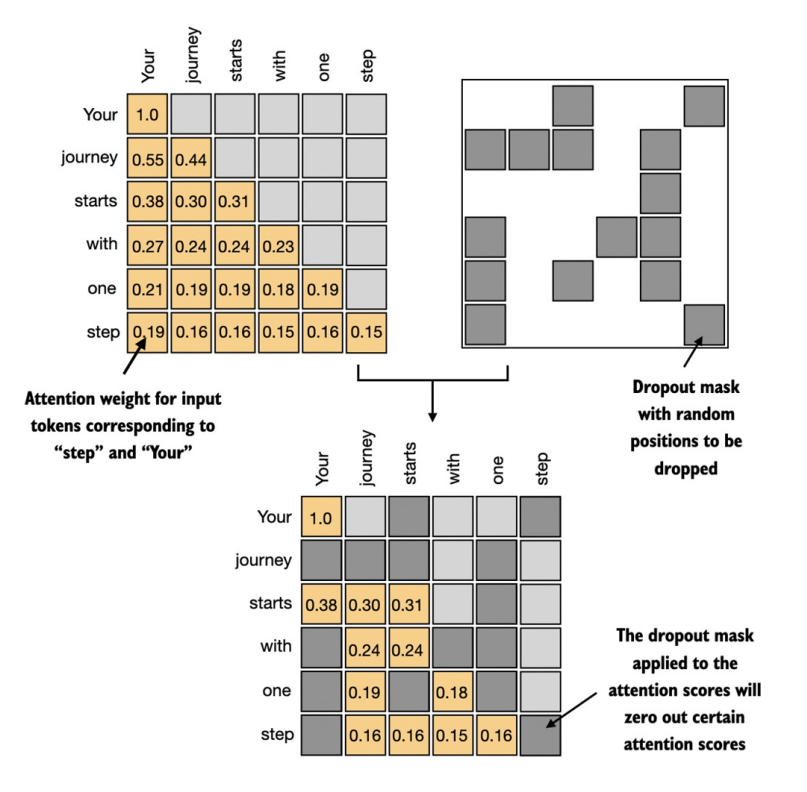

图3-22：使用因果注意力屏蔽（左上角），我们应用了一个额外的dropout屏蔽（右上角），将额外的注意力权重归零，以减少训练期间的过拟合。

In [43]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


当以50%的速率对注意力权重矩阵应用dropout时，矩阵中的一半元素会被随机设置为零。为了补偿活跃元素的减少，矩阵中剩余元素的值会按1/0.5=2的因子进行放大。这种缩放对于保持注意力权重的整体平衡至关重要，确保在训练和推理阶段，注意力机制的平均影响保持一致。

现在，让我们对注意力权重矩阵本身应用dropout：

In [42]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


请注意，根据你的操作系统，最终的dropout输出可能会有所不同；你可以在PyTorch问题跟踪器上（https://github.com/pytorch/pytorch/issues/121595）的此处了解更多关于这种不一致性的信息。

### 实现一个紧凑的因果注意力类

在本节中，我们将把因果注意力和dropout修改整合到我们在第3.4节中开发的SelfAttention Python类中。

但在开始之前，还有一件事要确保，那就是代码能够处理由多个输入组成的批次，以便CausalAttention类能够支持我们在第2章中实现的数据加载器产生的批量输出。

为了简化，为了模拟这样的批量输入，我们复制了输入文本示例：

In [44]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


- torch.stack: 这是PyTorch中的一个函数，用于将一系列张量（tensors）沿着一个新的维度合并起来。这个函数接受至少两个参数：一个张量列表（或元组）和一个指定的维度dim。
- (inputs, inputs): 这里创建了一个元组，其中包含两个相同的张量inputs。这意味着你想要将相同的张量复制一份，然后沿着某个维度将它们堆叠起来。

In [46]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

我们现在在__init__方法中添加了self.register_buffer()调用。在PyTorch中使用register_buffer并不是所有用例都严格必需的，但在这里它提供了几个优点。例如，当我们在大型语言模型（LLM）中使用CausalAttention类时，缓冲区会随着我们的模型自动移动到适当的设备（CPU或GPU）上，这在未来章节中训练LLM时将非常相关。这意味着我们不需要手动确保这些张量与模型参数在同一设备上，从而避免了设备不匹配错误。

我们可以像之前使用SelfAttention一样使用CausalAttention类，如下所示：

In [58]:
torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


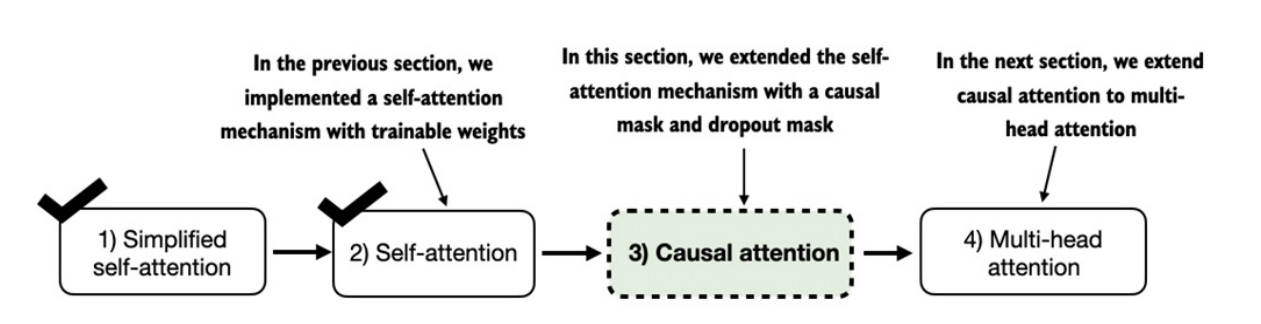

图3-23：心智模型，概括了本章中我们正在编码的四个不同的注意力模块。我们从一个简化的注意力机制开始，添加了可训练的权重，然后添加了因果注意力屏蔽。在本章的剩余部分，我们将扩展因果注意力机制，并编写多头注意力，这是我们在下一章实现大型语言模型（LLM）时将使用的最后一个模块。

## 将单头注意力扩展为多头注意力

“多头”一词指的是将注意力机制分成多个“头”，每个头独立运作。在这个上下文中，单个因果注意力模块可以被视为单头注意力，其中只有一组注意力权重按顺序处理输入。

### 堆叠多个单头注意力层

使用多个自注意力机制实例可能会在计算上非常密集，但对于像基于Transformer的大型语言模型（LLMs）这样的模型所擅长的复杂模式识别来说，这是至关重要的。

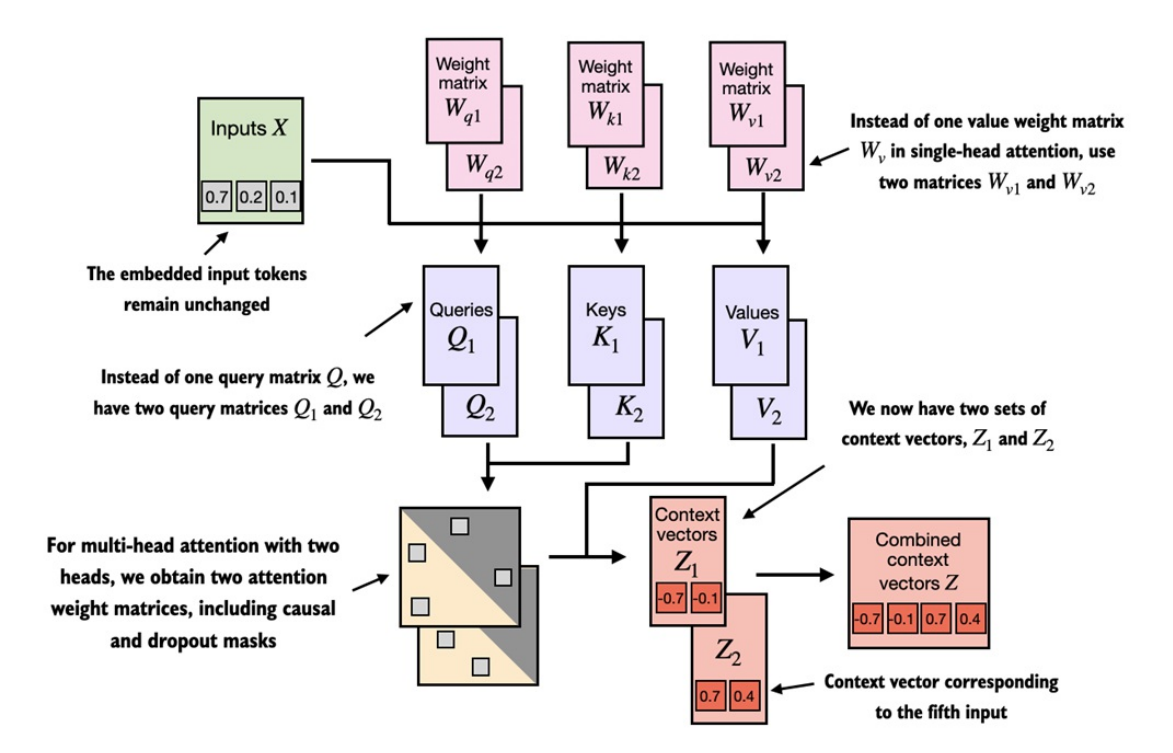

图3-24：多头注意力模块展示了两个单头注意力模块堆叠在一起的情况。因此，在具有两个头的多头注意力模块中，我们现在有两个值权重矩阵：Wv1和Wv2，而不是使用单个矩阵Wv来计算值矩阵。同样的道理也适用于其他权重矩阵Wq和Wk。我们获得了两组上下文向量Z1和Z2，可以将它们组合成一个单一的上下文向量矩阵Z。

多头注意力的主要思想是使用不同的、学习到的线性投影（即输入数据（如注意力机制中的查询、键和值向量）与权重矩阵相乘的结果）多次（并行）运行注意力机制。

在代码中，我们可以通过实现一个简单的MultiHeadAttentionWrapper类来实现这一点，该类堆叠了我们之前实现的CausalAttention模块的多个实例：

In [48]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

例如，如果我们使用具有两个注意力头（通过num_heads=2设置）和CausalAttention输出维度d_out=2的MultiHeadAttentionWrapper类，这将导致生成一个4维的上下文向量（d_out*num_heads=4）。

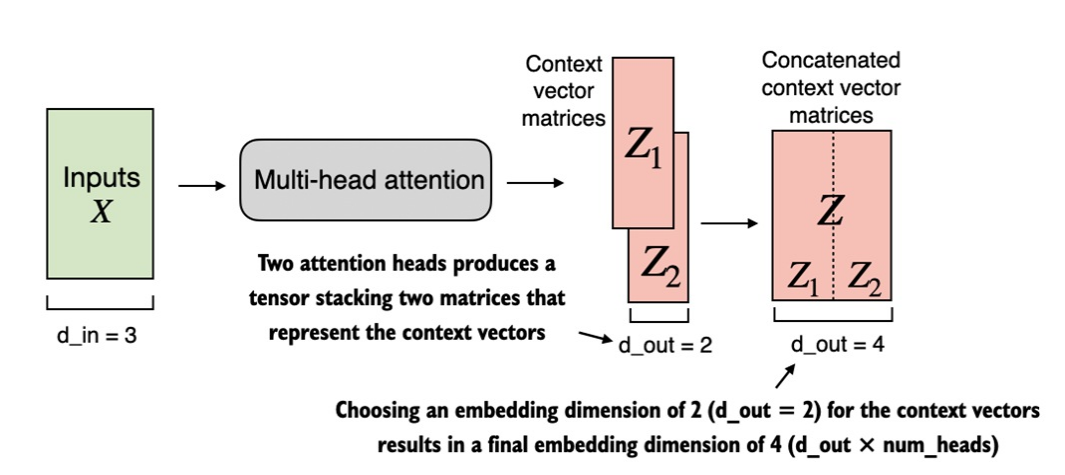

图3-25：使用MultiHeadAttentionWrapper，我们指定了注意力头的数量（num_heads）。如果我们如图中所示设置num_heads=2，我们将获得一个包含两组上下文向量矩阵的张量。在每个上下文向量矩阵中，行表示与标记相对应的上下文向量，列对应于通过d_out=4指定的嵌入维度。我们沿着列维度将这些上下文向量矩阵连接起来。由于我们有2个注意力头和2的嵌入维度，因此最终的嵌入维度是2 × 2 = 4。

我们可以像之前使用CausalAttention类一样使用MultiHeadAttentionWrapper类：

In [49]:
torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


生成的context_vecs张量的第一维是2，因为我们有两个输入文本（输入文本是重复的，所以它们的上下文向量完全相同）。第二维指的是每个输入中的6个标记。第三维指的是每个标记的4维嵌入。

#### 练习3.2 返回2维嵌入向量

修改MultiHeadAttentionWrapper(..., num_heads=2)调用的输入参数，使得输出的上下文向量是2维而不是4维，同时保持num_heads=2的设置不变。

提示：你不需要修改类的实现；你只需要改变其他输入参数中的一个。

### 使用权重分割实现多头注意力

与其维护两个独立的类（MultiHeadAttentionWrapper和CausalAttention），我们可以将这两个概念合并到一个单一的MultiHeadAttention类中。此外，除了仅仅将MultiHeadAttentionWrapper与CausalAttention代码合并之外，我们还将进行其他一些修改，以更高效地实现多头注意力。

MultiHeadAttention类将多头功能集成在一个类中。它通过重塑投影后的查询、键和值张量来将输入分成多个头，然后在计算注意力后将这些头的结果合并起来。

In [50]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

尽管MultiHeadAttention类内部对张量的重塑（.view）和转置（.transpose）看起来非常复杂，但从数学角度来看，MultiHeadAttention类实现的概念与之前的MultiHeadAttentionWrapper是相同的。

从大局来看，在之前的MultiHeadAttentionWrapper中，我们堆叠了多个单头注意力层，并将它们组合成一个多头注意力层。而MultiHeadAttention类则采用了集成的方法。它从一个多头层开始，然后在内部将这个层拆分成单个的注意力头。

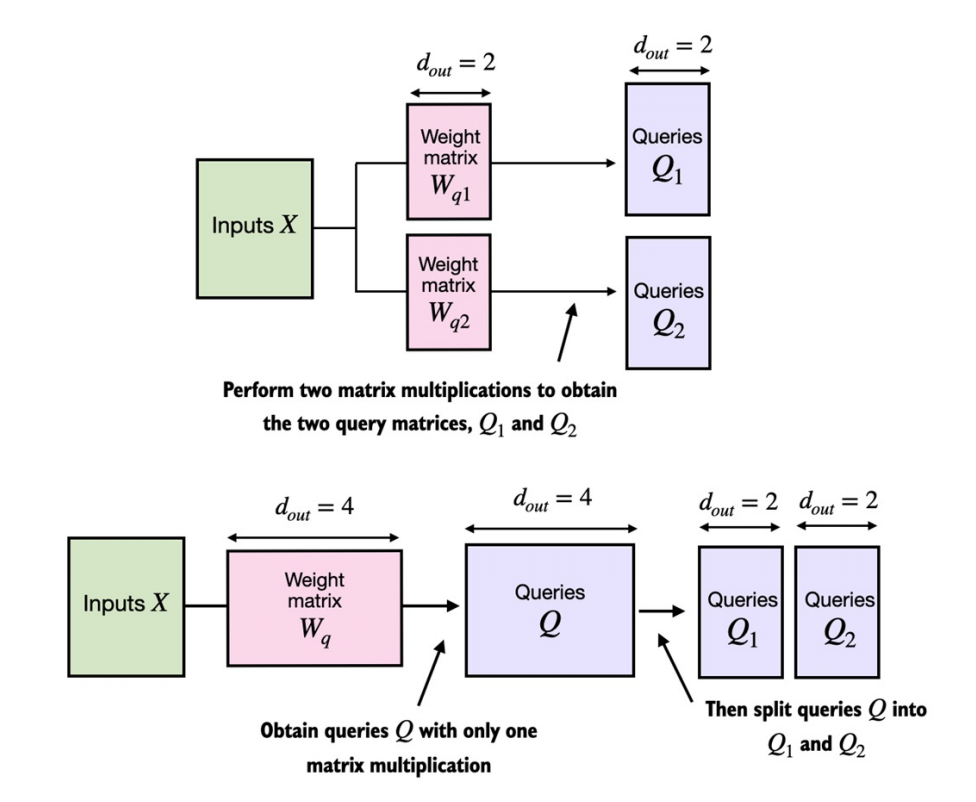

图3-26：在具有两个注意力头的MultiheadAttentionWrapper类中，我们初始化了两个权重矩阵Wq1和Wq2，并计算了两个查询矩阵Q1和Q2，如图顶部所示。在MultiheadAttention类中，我们初始化了一个更大的权重矩阵Wq，仅对输入执行一次矩阵乘法以获得查询矩阵Q，然后将查询矩阵拆分成Q1和Q2，如图底部所示。对于键和值，我们也做了同样的处理，但为了减少视觉上的杂乱，这里没有显示出来。

关键操作是将d_out维度拆分成num_heads和head_dim，其中head_dim = d_out / num_heads。然后使用.view方法实现这种拆分：将维度为(b, num_tokens, d_out)的张量重塑为维度(b, num_tokens, num_heads, head_dim)。

接着，对张量进行转置，将num_heads维度置于num_tokens维度之前，从而得到形状为(b, num_heads, num_tokens, head_dim)的张量。这种转置对于正确对齐不同头之间的查询、键和值以及高效执行批量矩阵乘法至关重要。

In [51]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

我们在张量本身和该张量的一个视图之间进行批量矩阵乘法运算，在这个视图中，我们将最后两个维度（num_tokens和head_dim）进行了转置：

In [52]:
print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


在这种情况下，PyTorch中的矩阵乘法实现会处理4维输入张量，使得矩阵乘法在最后两个维度（num_tokens, head_dim）之间进行，然后针对各个头重复这一过程。

例如，上述方法成为了一种更紧凑的计算方式，可以分别对每个头进行矩阵乘法：

In [53]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


在计算完注意力权重和上下文向量后，所有头的上下文向量会被转置回形状(b, num_tokens, num_heads, head_dim)。然后，这些向量会被重塑（展平）成形状(b, num_tokens, d_out)，从而有效地合并了所有头的输出。

尽管由于额外的张量重塑和转置操作，MultiHeadAttention类看起来比MultiHeadAttentionWrapper更复杂，但它实际上更高效。原因是，例如，我们只需要一次矩阵乘法来计算键（keys = self.W_key(x)），对于查询（queries）和值（values）也是如此。而在MultiHeadAttentionWrapper中，我们需要对每个注意力头都重复这个矩阵乘法操作，这是计算上最昂贵的步骤之一。

MultiHeadAttention类的使用方式与我们之前实现的SelfAttention和CausalAttention类类似：

In [54]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


#### 练习3.3 初始化GPT-2尺寸的注意力模块

使用MultiHeadAttention类，初始化一个具有与最小GPT-2模型相同数量注意力头（12个注意力头）的多头注意力模块。同时，确保你使用的输入和输出嵌入尺寸与GPT-2相似（768维）。请注意，最小的GPT-2模型支持1024个标记的上下文长度。

## 总结

- 注意力机制将输入元素转换为增强的上下文向量表示，该表示包含了所有输入的信息。自注意力机制通过计算输入上的加权和来得到上下文向量表示。
- 在简化的注意力机制中，注意力权重是通过点积来计算的。点积只是两个向量逐元素相乘然后求和的简洁方式。虽然矩阵乘法不是严格必需的，但它通过替换嵌套循环，帮助我们更高效、更紧凑地实现计算。
- 在大型语言模型（LLM）中使用的自注意力机制，也称为缩放点积注意力，我们包含了可训练的权重矩阵来计算输入的中间变换：查询、值和键。
- 当处理从左到右读取和生成文本的大型语言模型时，我们添加了一个因果注意力掩码，以防止模型访问未来的标记。
- 除了将注意力权重置为零的因果注意力掩码外，我们还可以添加丢弃掩码来减少大型语言模型中的过拟合。
- 基于Transformer的大型语言模型中的注意力模块涉及多个因果注意力的实例，这被称为多头注意力。我们可以通过堆叠多个因果注意力模块的实例来创建一个多头注意力模块。
- 创建多头注意力模块的一种更高效的方法是使用批量矩阵乘法。